# Autocorrelation Wavelet Packets

In [1]:
using Wavelets, Plots, DSP, StatsBase, LinearAlgebra
include("../src/AutocorrelationShell.jl")
using Main.AutocorrelationShell

### Implementation

In [2]:
function dyadlength(x)
"""
	dyadlength(x)

	Returns the dyadic length of a sequence `x`
"""
    return trunc(Integer, log2(length(x)))
end

dyadlength (generic function with 1 method)

In [3]:
function binary_ac1d(x, L, P, Q, wp_array, i, depth, max_depth)
    if depth <= max_depth
        wp_array[:,i] = x
        D = fwt_ac(x, L, P, Q)
        
        # left node
        left = D[:,1]
        binary_ac1d(left, L, P, Q, wp_array, 2*i, depth+1, max_depth)
        
        # right node
        right = D[:,2]
        binary_ac1d(right, L, P, Q, wp_array, 2*i+1, depth+1, max_depth)
    end
end

binary_ac1d (generic function with 1 method)

In [4]:
function ac1d_wpt(x, P, Q)
    max_depth = dyadlength(x) + 1
    max_node_index = 2^max_depth - 1
    L = max_depth - 2
    wpt_decomp = Array{Float64, 2}(undef, length(x), max_node_index)
    binary_ac1d(x, L, P, Q, wpt_decomp, 1, 1, max_depth)
    
    return wpt_decomp
end

ac1d_wpt (generic function with 1 method)

### Implementation Check

In [5]:
using Random
rng = MersenneTwister(123)

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

In [9]:
X₁ = randn(rng, 4) # length 4 random signal
H = wavelet(WT.db2)
Q = qfilter(H)
P = pfilter(H)
D₁ = ac1d_wpt(X₁, P, Q)

4×7 Array{Float64,2}:
 -0.396679   -0.542193  -0.0187958  …  -0.344412  -0.344412   0.31783 
 -0.664713   -0.263445  -0.6766        -0.147307  -0.147307  -0.80955 
  0.980968    0.43195    0.955348       0.344412   0.344412   1.00665 
 -0.0754831   0.153203  -0.259952       0.147307   0.147307  -0.514935

Here we check if the following relationship is satisfied:
$$S^{j-1}_k = \frac{1}{\sqrt{2}}(S^{j}_k + D^{j}_k)$$

In [10]:
D₁[:,1] - (D₁[:,2] + D₁[:,3]) / sqrt(2)

4-element Array{Float64,1}:
 -5.551115123125783e-17 
 -1.1102230246251565e-16
  2.220446049250313e-16 
 -2.7755575615628914e-17

In [11]:
D₁[:,2] - (D₁[:,4] + D₁[:,5]) / sqrt(2)

4-element Array{Float64,1}:
 -1.1102230246251565e-16
 -5.551115123125783e-17 
  5.551115123125783e-17 
  0.0                   

In [12]:
D₁[:,3] - (D₁[:,6] + D₁[:,7]) / sqrt(2)

4-element Array{Float64,1}:
  3.469446951953614e-18 
 -1.1102230246251565e-16
  2.220446049250313e-16 
 -5.551115123125783e-17 

All values are close to machine precision. Thus, the implementation is sound.

### Energy of Each Node

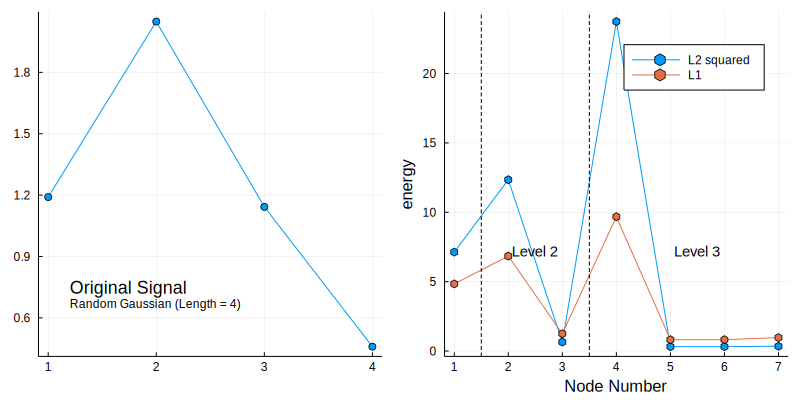

In [8]:
p₁ = plot(
    X₁,
    marker = (:circle),
    legend=false
)
annotate!(1.2, 0.75, text("Original Signal", :left, 12))
annotate!(1.2, 0.67, text("Random Gaussian (Length = 4)", :left, 8))

p₂ = plot(
    vec([norm(D₁[:,i], 2)^2 for i in 1:size(D₁)[2]]),
    marker = (:hexagon),
    xlabel="Node Number",
    ylabel="energy",
    label="L2 squared"
)
plot!(
    vec([norm(D₁[:,i], 1) for i in 1:size(D₁)[2]]),
    marker = (:hexagon),
    label="L1"
)
vline!(
    [1.5, 3.5], 
    style=:dash, 
    label=false, 
    color=:black
)
annotate!(2.5, 7.2, text("Level 2", :black, :center, 10))
annotate!(5.5, 7.2, text("Level 3", :black, :center, 10))

plot(p₁, p₂, layout=(1, 2), size=(800, 400))

### Sparsity Comparison
Here, we compare the averaged L1 norm of the child v.s. the L1 norm of the parent node.

In [15]:
norm_child = (norm(D₁[:,2], 1) + norm(D₁[:,3], 1)) / 2 
norm_parent =  norm(D₁[:,1], 1)
norm_child / norm_parent

0.7794458141223068

In [16]:
norm_child = (norm(D₁[:,4], 1) + norm(D₁[:,5], 1)) / 2 
norm_parent =  norm(D₁[:,2], 1)
norm_child / norm_parent

0.7071067811865475

In [17]:
norm_child = (norm(D₁[:,6], 1) + norm(D₁[:,7], 1)) / 2 
norm_parent =  norm(D₁[:,3], 1)
norm_child / norm_parent

0.9505458123489565

The averaged L1 norm of the child is smaller than that of the parent. Just in case, we will test L2 norm squared as well.

In [24]:
norm_child = (norm(D₁[:,2], 2)^2 + norm(D₁[:,3], 2)^2) / 2 
norm_parent =  norm(D₁[:,1], 2)^2
norm_child / norm_parent

0.6418592179942394

In [25]:
norm_child = (norm(D₁[:,4], 2)^2 + norm(D₁[:,5], 2)^2) / 2 
norm_parent =  norm(D₁[:,2], 2)^2
norm_child / norm_parent

0.510597191346355

In [26]:
norm_child = (norm(D₁[:,6], 2) + norm(D₁[:,7], 2)^2) / 2 
norm_parent =  norm(D₁[:,3], 2)^2
norm_child / norm_parent

0.8914906408217188

The averaged L2 norm of the child is smaller than that of the parent L2 norm.

### Other Types of Signals

In [27]:
X₂ = randn(rng, 8)
D₂ = ac1d_wpt(X₂, P, Q)

8×15 Array{Float64,2}:
  0.273815   0.285568   0.101665   …  -0.0484585  -0.0484585   0.315332
 -0.194229  -0.150308  -0.124373       0.0280696   0.0280696  -0.34412 
 -0.339366  -0.683597   0.203661       0.0825958   0.0825958   0.243319
 -0.843878  -1.12355   -0.0698759     -0.0500578  -0.0500578   0.111665
 -0.888936  -0.841754  -0.415391      -0.105012   -0.105012   -0.482374
  0.327215   0.116328   0.346424   …   0.079563    0.079563    0.465324
  0.592403   0.741291   0.0964932      0.0708743   0.0708743  -0.103421
  0.368002   0.659037  -0.138603      -0.0575748  -0.0575748  -0.205726

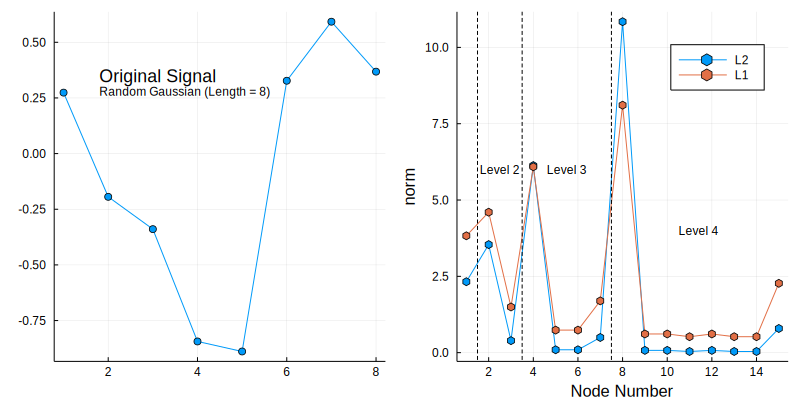

In [48]:
p₃ = plot(
    X₂,
    marker = (:circle),
    legend=false
)
annotate!(1.8, 0.35, text("Original Signal", :left, 12))
annotate!(1.8, 0.28, text("Random Gaussian (Length = 8)", :left, 8))

p₄ = plot(
    vec([norm(D₂[:,i], 2)^2 for i in 1:size(D₂)[2]]),
    marker = (:hexagon),
    xlabel="Node Number",
    ylabel="norm",
    label="L2"
)
plot!(
    vec([norm(D₂[:,i], 1) for i in 1:size(D₂)[2]]),
    marker = (:hexagon),
    label="L1"
)
vline!([1.5, 3.5, 7.5], style=:dash, color=:black, label=false)
annotate!(2.5, 6, text("Level 2", :black, :center, 8))
annotate!(5.5, 6, text("Level 3", :black, :center, 8))
annotate!(11.4, 4, text("Level 4", :black, :center, 8))

plot(p₃, p₄, layout=(1, 2), size=(800, 400))

In [29]:
X₃ = zeros(4)
X₃[3] = 1 # One Hot
D₃ = ac1d_wpt(X₃, P, Q)

4×7 Array{Float64,2}:
 0.0  -1.17757e-16   1.17757e-16  0.25  -0.25         -0.25          0.25
 0.0   0.353553     -0.353553     0.5    7.97973e-17   5.55112e-17  -0.5 
 1.0   0.707107      0.707107     0.75   0.25          0.25          0.75
 0.0   0.353553     -0.353553     0.5    7.11237e-17   7.11237e-17  -0.5 

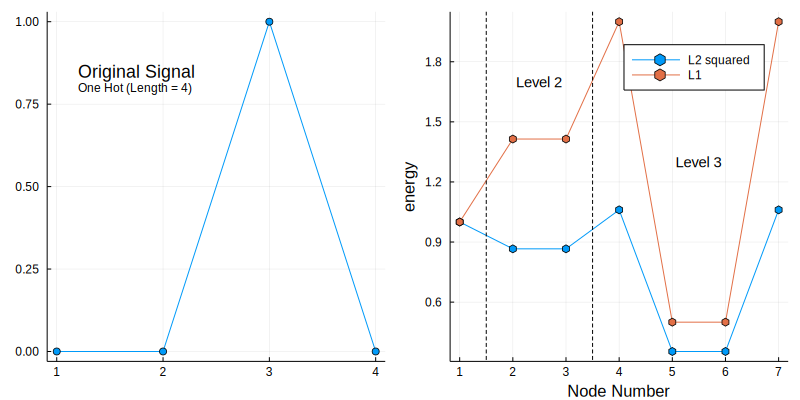

In [42]:
p₅ = plot(
    X₃,
    marker = (:circle),
    legend=false
)
annotate!(1.2, 0.85, text("Original Signal", :left, 12))
annotate!(1.2, 0.8, text("One Hot (Length = 4)", :left, 8))

p₆ = plot(
    vec([norm(D₃[:,i], 2) for i in 1:size(D₃)[2]]),
    marker = (:hexagon),
    xlabel="Node Number",
    ylabel="energy",
    label="L2 squared"
)
plot!(
    vec([norm(D₃[:,i], 1) for i in 1:size(D₃)[2]]),
    marker = (:hexagon),
    label="L1"
)
vline!([1.5, 3.5], style=:dash, color=:black, label=false)
annotate!(2.5, 1.7, text("Level 2", :black, :center, 10))
annotate!(5.5, 1.3, text("Level 3", :black, :center, 10))

plot(p₅, p₆, layout=(1, 2), size=(800, 400))

**Sparsity Check**

In [49]:
norm_child = (norm(D₃[:,2], 1) + norm(D₃[:,3], 1)) / 2 
norm_parent =  norm(D₃[:,1], 1)
norm_child / norm_parent

1.4142135623730951

In [50]:
norm_child = (norm(D₃[:,4], 1) + norm(D₃[:,5], 1)) / 2 
norm_parent =  norm(D₃[:,2], 1)
norm_child / norm_parent

0.883883476483184

In [51]:
norm_child = (norm(D₃[:,6], 1) + norm(D₃[:,7], 1)) / 2 
norm_parent =  norm(D₃[:,3], 1)
norm_child / norm_parent

0.8838834764831843

In [31]:
X₄ = zeros(8)
X₄[5] = 1 # One Hot
D₄ = ac1d_wpt(X₄, P, Q)

8×15 Array{Float64,2}:
 0.0   0.0           0.0          …   0.0497184   0.0497184  -0.149155 
 0.0  -0.0441942     0.0441942        0.0241687   0.0241687   0.0642197
 0.0  -5.88785e-17   5.88785e-17     -0.0883883  -0.0883883   0.265165 
 0.0   0.397748     -0.397748        -0.0241687  -0.0241687  -0.771326 
 1.0   0.707107      0.707107         0.127058    0.127058    1.03304  
 0.0   0.397748     -0.397748     …  -0.0241687  -0.0241687  -0.771326 
 0.0  -5.88785e-17   5.88785e-17     -0.0883883  -0.0883883   0.265165 
 0.0  -0.0441942     0.0441942        0.0241687   0.0241687   0.0642197

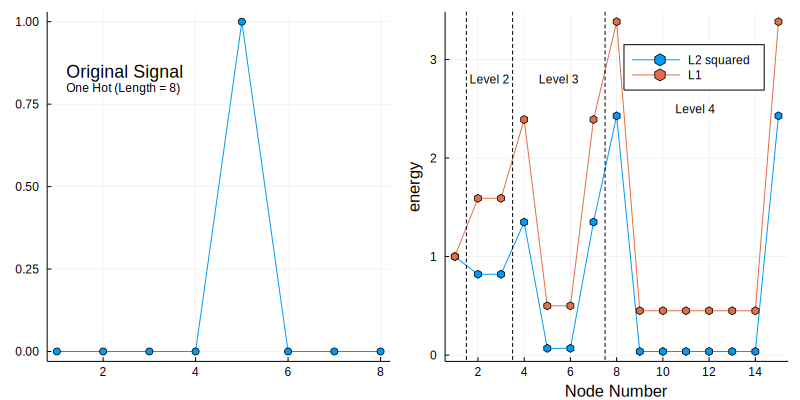

In [41]:
p₇ = plot(
    X₄,
    marker = (:circle),
    legend=false
)
annotate!(1.2, 0.85, text("Original Signal", :left, 12))
annotate!(1.2, 0.8, text("One Hot (Length = 8)", :left, 8))

p₈ = plot(
    vec([norm(D₄[:,i], 2)^2 for i in 1:size(D₄)[2]]),
    marker = (:hexagon),
    xlabel="Node Number",
    ylabel="energy",
    label="L2 squared"
)
plot!(
    vec([norm(D₄[:,i], 1) for i in 1:size(D₄)[2]]),
    marker = (:hexagon),
    label="L1"
)
vline!([1.5, 3.5, 7.5], style=:dash, color=:black, label=false)
annotate!(2.5, 2.8, text("Level 2", :black, :center, 8))
annotate!(5.5, 2.8, text("Level 3", :black, :center, 8))
annotate!(11.4, 2.5, text("Level 4", :black, :center, 8))

plot(p₇, p₈, layout=(1, 2), size=(800, 400))

In [33]:
X₅ = randn(rng, 256)
D₅ = ac1d_wpt(X₅, P, Q)

256×511 Array{Float64,2}:
 -0.281133   0.01018    -0.407762   -0.355728  …  -0.060424     -8.61182 
 -0.734886  -0.7568     -0.282485   -0.883324     -0.47855       3.88787 
 -0.71741   -1.1679      0.153332   -1.56575       0.457498     -1.16701 
 -0.77507   -1.18989     0.0937713  -1.60786       0.0237043     1.17842 
 -0.979539  -0.825938   -0.559339   -1.14647      -0.352682     -2.22069 
  0.260402  -0.372386    0.74065    -0.808509  …   0.149226      2.66362 
 -0.468489  -0.611167   -0.0513769  -0.777796      0.252385     -2.65053 
 -0.880897  -0.576909   -0.668868   -0.304584     -0.230512      3.06788 
  0.277726   0.570257   -0.177493    0.484004     -0.238187     -3.56555 
  1.52392    0.467083    1.68806    -0.1739        0.472388      2.73089 
 -1.77773   -1.88084    -0.633244   -2.16517   …  -0.0578838    -0.41135 
 -2.93306   -2.44371    -1.70426    -2.43282      -0.489562     -1.19527 
  0.782258   0.224116    0.882164   -0.156689      0.450754     -0.373313
  ⋮         

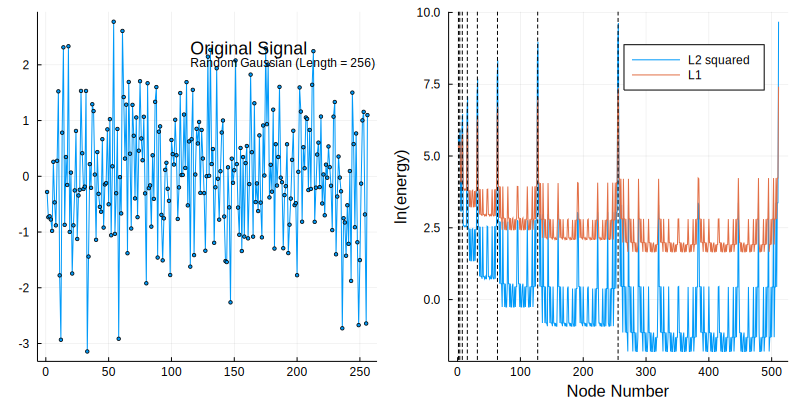

In [39]:
p₉ = plot(
    X₅,
    marker = (:circle, 2),
    legend=false
)
annotate!(115, 2.3, text("Original Signal", :left, 12))
annotate!(115, 2.04, text("Random Gaussian (Length = 256)", :left, 8))

p₁₀ = plot(
    log.(vec([norm(D₅[:,i], 2)^2 for i in 1:size(D₅)[2]])),
    xlabel="Node Number",
    ylabel="ln(energy)",
    label="L2 squared"
)
plot!(
    log.(vec([norm(D₅[:,i], 1) for i in 1:size(D₅)[2]])),
    label="L1"
)
vline!([1.5, 3.5, 7.5, 15.5, 31.5, 63.5, 127.5, 255.5], style=:dash, label=false, color=:black)

plot(p₉, p₁₀, layout=(1, 2), size=(800, 400))

In [35]:
x₁ = [sin(2π*8*(i/256)) for i in 1:256]
x₂ = [sin(2π*4*(i/256)) for i in 1:256]
x₃ = [sin(2π*2*(i/256)) for i in 1:256]
x₄ = [sin(2π*(i/256)) for i in 1:256]
x₅ = [cos(2π*5(i/256)) for i in 1:256]

X = (x₁ + x₂ + x₃ + x₄ + x₅) / 5

256-element Array{Float64,1}:
  0.2718391799589458  
  0.33897796444654815 
  0.3998285494327665  
  0.4529637880491363  
  0.49716840347652125 
  0.5314832085191344  
  0.5552406299346349  
  0.5680901537174735  
  0.5700126794015452  
  0.5613231829870627  
  0.542661523695178   
  0.514971672860292   
  0.4794700770240447  
  ⋮                   
 -0.4550210276324303  
 -0.4265672416301752  
 -0.3901681475397028  
 -0.3458620605096334  
 -0.2939714927531253  
 -0.23510275837715203 
 -0.17013447821588767 
 -0.10019528230979395 
 -0.026631429898870972
  0.04903453683126913 
  0.12515263388053768 
  0.19999999999999926 

In [36]:
D₆ = ac1d_wpt(X, P, Q)

256×511 Array{Float64,2}:
  0.271839    0.384411    2.75561e-5  …   8.39193e-17   1.63924e-15
  0.338978    0.479345    4.2378e-5      -1.04209e-18  -8.73783e-16
  0.399829    0.565387    5.58715e-5     -6.10702e-17  -8.58185e-18
  0.452964    0.64052     6.75217e-5      6.62263e-17   5.0165e-16 
  0.497168    0.703025    7.68804e-5     -3.17933e-17  -4.31207e-16
  0.531483    0.751547    8.35829e-5  …  -1.23407e-17  -1.38774e-19
  0.555241    0.785141    8.73626e-5      4.41199e-17   4.05625e-16
  0.56809     0.803313    8.80614e-5     -4.75557e-17  -4.69664e-16
  0.570013    0.806034    8.5636e-5       1.97289e-17   1.25862e-16
  0.561323    0.793751    8.01597e-5      1.95254e-17   4.29397e-16
  0.542662    0.767367    7.18202e-5  …  -3.98998e-17  -8.92803e-16
  0.514972    0.728219    6.09126e-5      2.73469e-17   1.06859e-15
  0.47947     0.678025    4.78287e-5      3.87119e-18  -9.79684e-16
  ⋮                                   ⋱                 ⋮          
 -0.455021   -0.64343 

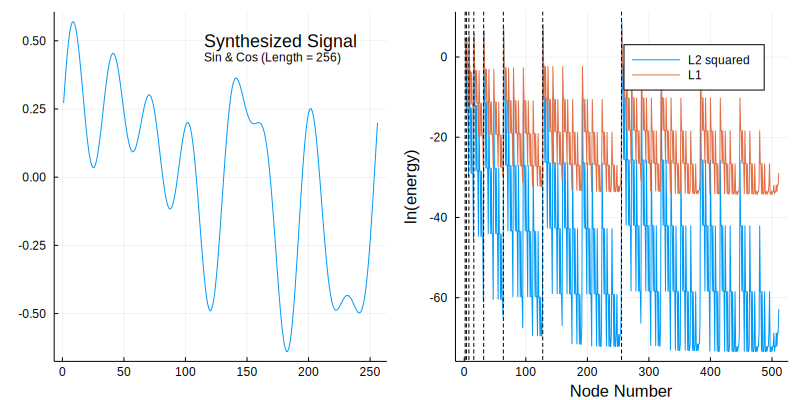

In [40]:
P₁ = plot(
    X,
    legend=false
)
annotate!(115, 0.5, text("Synthesized Signal", :left, 12))
annotate!(115, 0.44, text("Sin & Cos (Length = 256)", :left, 8))

P₂ = plot(
    log.(vec([norm(D₆[:,i], 2)^2 for i in 1:size(D₆)[2]])),
    xlabel="Node Number",
    ylabel="ln(energy)",
    label="L2 squared"
)
plot!(
    log.(vec([norm(D₆[:,i], 1) for i in 1:size(D₆)[2]])),
    label="L1"
)
vline!([1.5, 3.5, 7.5, 15.5, 31.5, 63.5, 127.5, 255.5], style=:dash, color=:black, label=false)

plot(P₁, P₂, layout=(1, 2), size=(800, 400))

**Sparsity Check**

In [52]:
norm_child = (norm(D₆[:,2], 1) + norm(D₆[:,3], 1)) / 2 
norm_parent =  norm(D₆[:,1], 1)
norm_child / norm_parent

0.7071548682786825

In [53]:
norm_child = (norm(D₆[:,4], 1) + norm(D₆[:,5], 1)) / 2 
norm_parent =  norm(D₆[:,2], 1)
norm_child / norm_parent

0.7071548562172768

In [54]:
norm_child = (norm(D₆[:,6], 1) + norm(D₆[:,7], 1)) / 2 
norm_parent =  norm(D₆[:,3], 1)
norm_child / norm_parent

0.7071068051802477

In [76]:
x₁ = [0.63662 * sin(2π*(i/256)) for i in 1:256]
x₂ = [-0.31088 * sin(2π*2*(i/256)) for i in 1:256]
x₃ = [0.2122 * sin(2π*3*(i/256)) for i in 1:256]
x₄ = [-0.15915 * sin(2π*4*(i/256)) for i in 1:256]
x₅ = [0.12731 * sin(2π*5*(i/256)) for i in 1:256]
x₆ = [-0.10609 * sin(2π*6*(i/256)) for i in 1:256]
x₇ = [0.09093 * sin(2π*7*(i/256)) for i in 1:256]
x₈ = [-0.07956 * sin(2π*8*(i/256)) for i in 1:256]
x₉ = [0.07072 * sin(2π*8*(i/256)) for i in 1:256]

X = (x₁ + x₂ + x₃ + x₄ + x₅)

256-element Array{Float64,1}:
  0.01596435387936078   
  0.03178728287871253   
  0.04732981645764684   
  0.06245785138604154   
  0.07704448265327118   
  0.0909722129653152    
  0.10413500346526613   
  0.11644013091140602   
  0.12780981971679084   
  0.13818262094458728   
  0.1475145145053467    
  0.15577971534964072   
  0.16297116931933336   
  ⋮                     
 -0.14751451450534675   
 -0.13818262094458733   
 -0.12780981971679062   
 -0.11644013091140637   
 -0.10413500346526643   
 -0.09097221296531516   
 -0.07704448265327155   
 -0.06245785138604149   
 -0.04732981645764675   
 -0.03178728287871317   
 -0.01596435387936096   
 -1.5954943428651545e-16

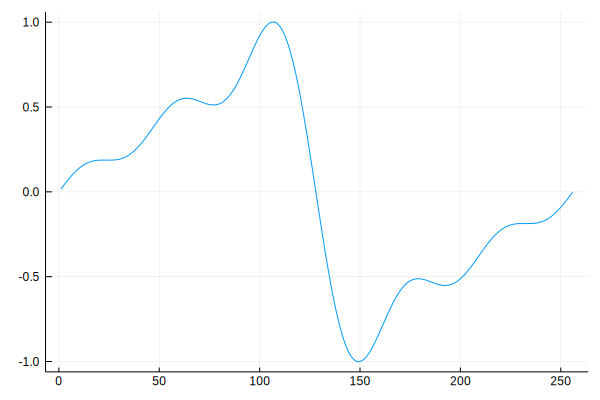

In [82]:
P₂ = plot(
    X,
    legend=false
)

In [78]:
D₇ = ac1d_wpt(X, P, Q)

256×511 Array{Float64,2}:
  0.0159644     0.0225764     6.48977e-7   …  -8.05708e-17   6.76419e-16
  0.0317873     0.0449527     1.28701e-6       4.19193e-17  -8.31279e-17
  0.0473298     0.0669326     1.90335e-6       5.09172e-18  -8.29685e-17
  0.0624579     0.0883263     2.48758e-6      -2.07359e-17   2.4211e-17 
  0.0770445     0.108954      3.02982e-6       1.22676e-17   7.36902e-17
  0.0909722     0.128651      3.52089e-6   …  -1.13927e-18  -1.44548e-16
  0.104135      0.147265      3.95241e-6      -3.56235e-18   1.99596e-16
  0.11644       0.164667      4.31702e-6       3.42757e-18  -2.59369e-16
  0.12781       0.180746      4.60844e-6      -8.4694e-19    3.22099e-16
  0.138183      0.195415      4.82158e-6      -2.72563e-18  -3.64881e-16
  0.147515      0.208612      4.95265e-6   …   4.46968e-18   3.60399e-16
  0.15578       0.220301      4.99923e-6      -2.33485e-18  -2.96771e-16
  0.162971      0.230471      4.96025e-6      -1.11896e-18   1.85693e-16
  ⋮                      

In [91]:
norm_child = (norm(D₇[:,2], 1) + norm(D₇[:,3], 1)) / 2 
norm_parent =  norm(D₇[:,1], 1)
norm_child / norm_parent

0.7071108930942468

In [93]:
norm_child = (norm(D₇[:,4], 1) + norm(D₇[:,5], 1)) / 2 
norm_parent =  norm(D₇[:,2], 1)
norm_child / norm_parent

0.7071108929316061

In [94]:
norm_child = (norm(D₇[:,6], 1) + norm(D₇[:,7], 1)) / 2 
norm_parent =  norm(D₇[:,3], 1)
norm_child / norm_parent

0.7071074512120125

In [87]:
X = zeros(8)
X[1], X[2] = 1, 1 # One Hot
X[5], X[6] = 1, 1 # One Hot

(1, 1)

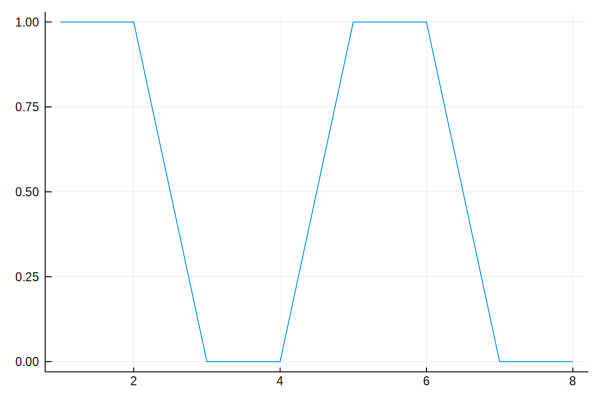

In [88]:
P₃ = plot(
    X,
    legend=false
)

In [89]:
D = ac1d_wpt(X, P, Q)

8×15 Array{Float64,2}:
 1.0  1.06066    0.353553  1.25   0.25  …   0.176777   0.176777   0.176777
 1.0  1.06066    0.353553  1.25   0.25      0.176777   0.176777   0.176777
 0.0  0.353553  -0.353553  0.75  -0.25     -0.176777  -0.176777  -0.176777
 0.0  0.353553  -0.353553  0.75  -0.25     -0.176777  -0.176777  -0.176777
 1.0  1.06066    0.353553  1.25   0.25      0.176777   0.176777   0.176777
 1.0  1.06066    0.353553  1.25   0.25  …   0.176777   0.176777   0.176777
 0.0  0.353553  -0.353553  0.75  -0.25     -0.176777  -0.176777  -0.176777
 0.0  0.353553  -0.353553  0.75  -0.25     -0.176777  -0.176777  -0.176777

In [95]:
norm_child = (norm(D[:,2], 1) + norm(D[:,3], 1)) / 2 
norm_parent =  norm(D[:,1], 1)
norm_child / norm_parent

1.0606601717798212

In [96]:
norm_child = (norm(D[:,4], 1) + norm(D[:,5], 1)) / 2 
norm_parent =  norm(D[:,2], 1)
norm_child / norm_parent

0.8838834764831843

In [97]:
norm_child = (norm(D[:,6], 1) + norm(D[:,7], 1)) / 2 
norm_parent =  norm(D[:,3], 1)
norm_child / norm_parent

0.7071067811865475

### Saw Tooth

In [136]:
N = 10000
L = 256 # lenght
A = 1 # Amplitude

1

In [143]:
Σ = Array{Float64, 2}(undef, N, L)
for k in 1:N
    for t in 1:256
        Σ[k, t] = A/2 - A/π * (-1)^k * sin(2*π*k*t/256) / k
    end
end
σ = vec(sum(Σ, dims=1)) / N

256-element Array{Float64,1}:
 0.5000003899979254 
 0.500000780097034  
 0.5000011703822407 
 0.5000015609085303 
 0.5000019516920922 
 0.5000023427076752 
 0.5000027338925944 
 0.5000031251567539 
 0.5000035163970931 
 0.5000039075141426 
 0.5000042984280453 
 0.500004689091468  
 0.500005079497326  
 ⋮                  
 0.49999570157195466
 0.4999960924858574 
 0.49999648360290694
 0.49999687484324606
 0.49999726610740564
 0.49999765729232476
 0.49999804830790784
 0.4999984390914697 
 0.49999882961775927
 0.499999219902966  
 0.4999996100020746 
 0.5                

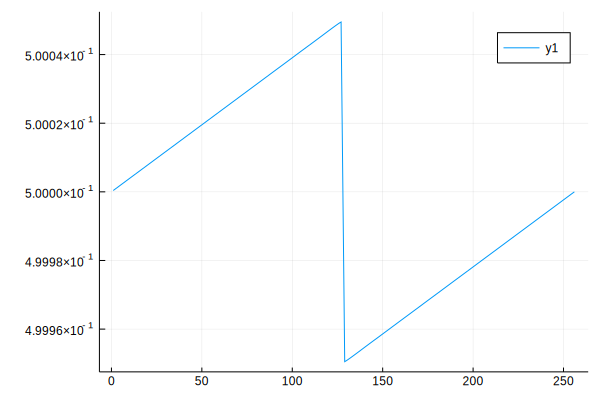

In [144]:
plot(σ)

In [145]:
D = ac1d_wpt(σ, P, Q)

256×511 Array{Float64,2}:
 0.5       0.707107  -4.19855e-12  1.0       …  -3.34246e-18  -7.04747e-17
 0.500001  0.707108  -7.7244e-12   1.0           1.21957e-17   8.0608e-17 
 0.500001  0.707108  -1.00123e-11  1.0          -1.50443e-17   2.16984e-17
 0.500002  0.707109  -1.06946e-11  1.0           9.19595e-18  -2.35734e-16
 0.500002  0.70711   -9.6602e-12   1.0           7.39192e-18   4.7386e-16 
 0.500002  0.70711   -7.07287e-12  1.0       …  -2.46907e-17  -5.99741e-16
 0.500003  0.707111  -3.34451e-12  1.00001       2.22645e-17   5.23836e-16
 0.500003  0.707111   9.28729e-13  1.00001       4.90556e-18  -2.92945e-16
 0.500004  0.707112   5.0631e-12   1.00001      -3.08451e-17   6.95535e-17
 0.500004  0.707112   8.39507e-12  1.00001       2.4548e-17    1.48929e-17
 0.500004  0.707113   1.03877e-11  1.00001   …   1.00606e-17   6.36382e-18
 0.500005  0.707113   1.07172e-11  1.00001      -3.48844e-17   2.831e-17  
 0.500005  0.707114   9.32511e-12  1.00001       2.2457e-17   -2.26843e-16

In [146]:
norm_child = (norm(D[:,2], 1) + norm(D[:,3], 1)) / 2 
norm_parent =  norm(D[:,1], 1)
norm_child / norm_parent

0.7071069530740102

In [147]:
norm_child = (norm(D[:,4], 1) + norm(D[:,5], 1)) / 2 
norm_parent =  norm(D[:,2], 1)
norm_child / norm_parent

0.7071068747264042

In [148]:
norm_child = (norm(D[:,6], 1) + norm(D[:,7], 1)) / 2 
norm_parent =  norm(D[:,3], 1)
norm_child / norm_parent

0.928086324236227

### Square

In [149]:
Σ = Array{Float64, 2}(undef, N, L)
for k in 1:N
    for t in 1:256
        Σ[k, t] = 4/π * sin(2*π*(2k-1)*t/256) / (2k - 1)
    end
end
σ = vec(sum(Σ, dims=1)) / N

256-element Array{Float64,1}:
  9.990809928902094e-5  
  9.999993397581685e-5  
  0.00010003057536059947
  0.0001000324749039046 
  0.00010001839465787508
  0.00010000000731228285
  9.99868383424734e-5   
  9.998368397561323e-5  
  9.998972487914199e-5  
  9.999999738504595e-5  
  0.00010000843748155726
  0.00010001096543817277
  0.00010000717648193611
  ⋮                     
 -0.00010000843748155673
 -9.999999738504648e-5  
 -9.998972487914015e-5  
 -9.998368397561286e-5  
 -9.998683834247438e-5  
 -0.00010000000731228644
 -0.00010001839465787454
 -0.00010003247490390484
 -0.00010003057536059912
 -9.999993397581691e-5  
 -9.990809928902242e-5  
 -3.120252068457058e-16 

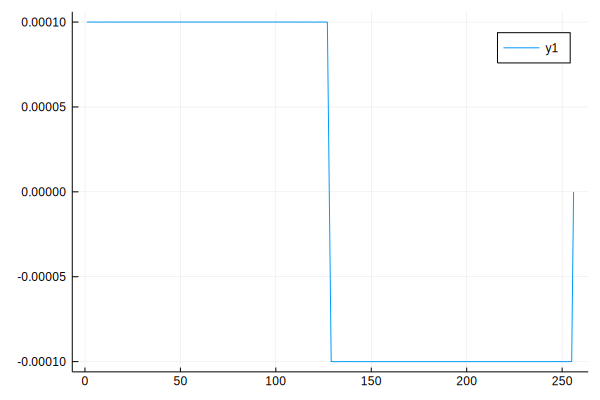

In [150]:
plot(σ)

In [151]:
D = ac1d_wpt(σ, P, Q)

256×511 Array{Float64,2}:
  9.99081e-5    0.000110419   3.08724e-5   …   7.68975e-6    6.73791e-5 
  9.99999e-5    0.000150231  -8.80962e-6      -6.79765e-6   -9.03539e-5 
  0.000100031   0.000145875  -4.41069e-6      -2.89679e-7    6.43377e-5 
  0.000100032   0.000141468  -1.15763e-9       4.79687e-6   -2.12822e-5 
  0.000100018   0.000141448  -6.36726e-10     -3.29107e-6   -6.4876e-6  
  0.0001        0.000141423  -1.17909e-9   …  -2.30459e-7    1.15368e-5 
  9.99868e-5    0.000141404  -1.38486e-9       1.57915e-6   -5.48912e-6 
  9.99837e-5    0.000141399  -1.02943e-9      -8.04248e-7    2.00433e-7 
  9.99897e-5    0.000141407  -2.89977e-10     -8.95683e-8    1.12003e-6 
  0.0001        0.000141421   4.64558e-10      2.52636e-7   -5.36907e-7 
  0.000100008   0.000141432   8.84749e-10  …  -7.65928e-8    1.46466e-8 
  0.000100011   0.000141436   8.12864e-10     -2.40997e-8    7.86235e-8 
  0.000100007   0.000141431   3.44822e-10      2.00436e-8   -2.60888e-8 
  ⋮                      

In [152]:
norm_child = (norm(D[:,2], 1) + norm(D[:,3], 1)) / 2 
norm_parent =  norm(D[:,1], 1)
norm_child / norm_parent

0.7091906365315729

In [153]:
norm_child = (norm(D[:,4], 1) + norm(D[:,5], 1)) / 2 
norm_parent =  norm(D[:,2], 1)
norm_child / norm_parent

0.7081952195390535

In [154]:
norm_child = (norm(D[:,6], 1) + norm(D[:,7], 1)) / 2 
norm_parent =  norm(D[:,3], 1)
norm_child / norm_parent

0.9280212332693857